In [1]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [3]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):
    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [4]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [8]:
# Problem 2.1
# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    n_iter = 0
    e = 100
    cost_list = []
    # Init
    W, w0 = Initialw(X, y)
    W_prev = np.copy(W)
    w0_prev = w0
    
    H_theta = w0 + X.dot(W)
    
    while((e>epsilon) and (n_iter<max_iter)):
        # coordinate descent algorithm
        w0 = w0 - (1/X.shape[0])*(H_theta-y).sum()
        #w0 = (H_theta-y).sum()/X.shape[0]
        for k in range(X.shape[1]): # number of features
            Rk = y - (X.dot(W)-X[:,k]*W[k])
            Ak = 2*np.square(X[:,k]).sum()
            Ck = 2*(Rk*X[:,k]).sum()
            Tk = np.sign(Ck)*max(0,abs(Ck)-lmda)/Ak
            W[k] = Tk
                
        H_theta = w0 + X.dot(W)
        cost = round(((H_theta-y)*(H_theta-y)).sum() + lmda*(np.absolute(W)).sum(),2)
        cost_list.append(cost)
        
        # (Stopping criteria) Update e and iter++
        n_iter += 1
        if (n_iter > 0):
            e = max(np.max(np.absolute(W-W_prev)), abs(w0-w0_prev))
        W_prev = np.copy(W)
        w0_prev = w0
    
    #print("y: ", y[0:4])
    #print("H: ", H_theta[0:4])
    if (draw_curve == True):
        plt.plot(list(range(0,len(cost_list))), cost_list)
        plt.title("# Cost function")
        plt.xlabel("# of Coordination step")
        plt.ylabel("Cost Function")
        plt.show()

    return (W,w0)

In [9]:
# Problem 2.1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0) # n = 50, m = 75, σ = 1.0, θ0 = 0.0 
# have a look at generated data and true model
print(X.var())
print(y.var())
print(w_true)
print(w0_true)

1.020430485518565
483.980968404896
[ 10. -10. -10.  10.  10.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]
0.0


Problem 3(a) - Plot the objective value F(θ,θ0) v.s. coordinate descent step


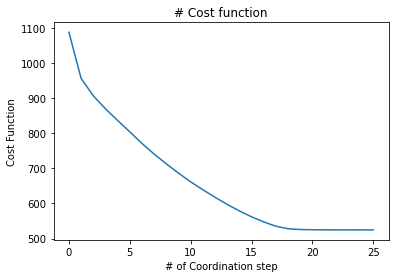

Problem 3(a) - report indices of non-zero weight entries
[ 9.87701 -9.72978 -9.78533  9.85809 10.08127  0.      -0.       0.04991
 -0.      -0.      -0.      -0.0203   0.22101 -0.       0.10649 -0.
  0.12529  0.      -0.      -0.       0.       0.01886  0.01338  0.01045
  0.      -0.02633 -0.       0.      -0.       0.      -0.      -0.
  0.       0.       0.08118  0.      -0.0671  -0.      -0.      -0.
  0.       0.       0.       0.       0.       0.      -0.       0.
  0.04079 -0.       0.      -0.       0.25101 -0.      -0.01948 -0.
  0.       0.      -0.       0.      -0.      -0.03668  0.      -0.13302
  0.       0.      -0.       0.       0.       0.      -0.      -0.05598
 -0.       0.       0.     ]
0.16058376499246424


In [10]:
# Problem 2.1: run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
print("Problem 3(a) - Plot the objective value F(θ,θ0) v.s. coordinate descent step")
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print("Problem 3(a) - report indices of non-zero weight entries")
np.set_printoptions(suppress=True)
print(np.round(w_lasso,5))
print(w0_lasso)

In [11]:
import math
# Problem 2.2
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########    
    precision_w = (np.count_nonzero(w*w_true) + np.count_nonzero(w0*w0_true)) \
                    / (np.count_nonzero(w) + np.count_nonzero(w0) )
    
    recall_w = (np.count_nonzero(w*w_true) + np.count_nonzero(w0*w0_true)) \
                    / (np.count_nonzero(w_true) + np.count_nonzero(w0_true) )
    
    sparsity_w = np.count_nonzero(w) + np.count_nonzero(w0)
    
    H_theta = w0 + X.dot(w)
    rmse =  math.sqrt( 1/X.shape[0]*(np.square(H_theta-y)).sum() )

    return (rmse, sparsity_w, precision_w, recall_w)

In [12]:
print("Problem 3(b)")
# Problem 2.2
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
#Emetric = Evaluate(X, y, wl, wl0, w_true, w0_true)
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print("rmse: {}, sparsity_w: {}, precision_w: {:.0%}, recall_w: {:.0%}".format(Emetric[0], Emetric[1], Emetric[2], Emetric[3]))


Problem 3(b)
rmse: 0.6112410783714388, sparsity_w: 23, precision_w: 22%, recall_w: 100%


In [33]:
# Problem 2.3
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y):
    #########TODO##########
    
    lmda = np.linspace(np.max(np.abs((y-np.mean(y)).dot(X))), 0, num=50)
    #lmda = np.linspace(np.max(np.abs( ( (y-np.mean(y)).multiply(X)) )), 0, num=50)
    
    w_lasso_list = []
    for l in lmda:
        w_lasso, w0_lasso = lasso(X, y, lmda = l, epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
        #w_lasso, w0_lasso = lasso_sparse(X, y, lmda = l, epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
        w_lasso_list.append(w_lasso)
    
    #lasso solution path
    # use λ as the x-axis, for each entry θi in θ achieved by lasso, plot the curve of θi vs. λ
    w_lasso_list2 = []
    for i in range(X.shape[1]):
        w_ith = []
        for j in range(len(lmda)):
            w_ith.append(w_lasso_list[j][i])
        w_lasso_list2.append(w_ith)
    
    for l in range(len(lmda)):
        if (l<5):
            plt.plot(lmda, w_lasso_list2[l], color='red')
        else:
            plt.plot(lmda, w_lasso_list2[l], color='blue')
    #plt.xlim([0, 30])
    plt.xlabel("lamda")
    plt.ylabel("Weigh")
    plt.show()
    
    W=w_lasso
    W0=w0_lasso
    Lmda=lmda
    return (W, W0, Lmda)

In [34]:
# Problem 2.3
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda):
    #########TODO##########
    #lmda = np.linspace(np.max(np.abs((y-np.mean(y)).dot(X))), 0, num=50)
    precision_list = []
    recall_list = []
    rmse_list = []
    sparsity_list = []
    for l in Lmda: 
        W, W0 = lasso(X, y, lmda = l, epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
        #W, W0 = lasso_sparse(X, y, lmda = l, epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
        Emetric = Evaluate(X, y, W, W0, w_true, w0_true)
        precision_list.append(Emetric[2])
        recall_list.append(Emetric[3])
        rmse_list.append(Emetric[0])
        sparsity_list.append(Emetric[1])
        
    # Plot Precision and Recall
    plt.plot(Lmda, precision_list, color='blue', label='precision')
    plt.plot(Lmda, recall_list, color='red', label = 'recall')
    plt.title("Evaluation")
    plt.xlabel("lamda")
    plt.ylabel("precision,recall")
    plt.legend()
    plt.show()
    
    """
    plt.plot(Lmda, rmse_list, color='green', label = 'rmse')
    plt.xlabel("lamda")
    plt.ylabel("rmse")
    plt.show()
    
    plt.plot(Lmda, sparsity_list, color='green', label = 'sparsity')
    plt.xlabel("lamda")
    plt.ylabel("sparsity")
    plt.show()
    """
    
    RMSE = rmse_list
    Sparsity = sparsity_list
    Precision = precision_list
    Recall = recall_list

    return (RMSE, Sparsity, Precision, Recall)

Problem 3(c)
-- sigma = 1.0


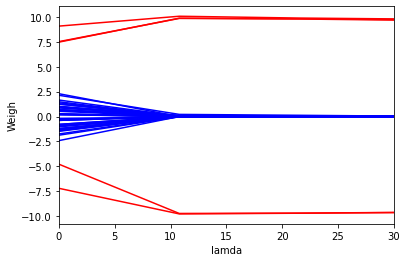

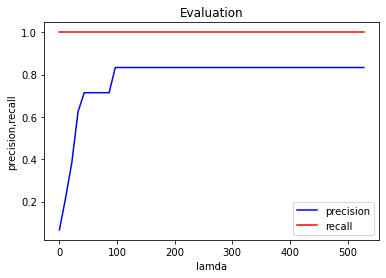

In [15]:
# Problem 2.3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
print("Problem 3(c)")
print("-- sigma = 1.0")
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)
RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

-- sigma = 10


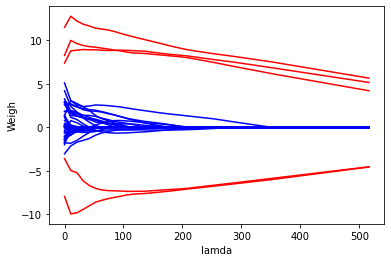

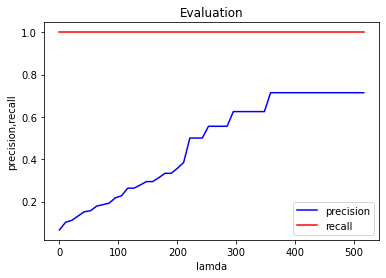

Q) Compare the two solution path plots with different σ, and explain their difference.
--> Noisier data need more regluarization
--> If σ is large, noisy data is more largly distributed. When σ=1, without giving a high regularization term, lamda, it finds optimal solution easily. However, when there are many noise, bigger regularization is better to reduce the effect to avoid overfitting. As the graph shows, large regularization term is needed to reach a good precision. Large lamda controls the excessively fluctuating function such that the coefficients don’t take extreme values.


In [18]:
# Problem 2.3
# TODO: try a larger std sigma = 10.0
print("-- sigma = 10")
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
W, W0, Lmda = LassoPath(X, y)
RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)
print("Q) Compare the two solution path plots with different σ, and explain their difference.")
print("--> Noisier data need more regluarization")
print("--> If σ is large, noisy data is more largly distributed. When σ=1, without giving a high regularization term, lamda, \
it finds optimal solution easily. However, when there are many noise, bigger regularization \
is better to reduce the effect to avoid overfitting. As the graph shows, large regularization term is needed to reach a good precision. \
Large lamda controls the excessively fluctuating function such that the coefficients don’t take extreme values." )


Problem 3(d)
(n = 50,m = 75)


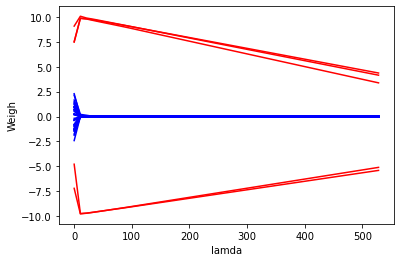

(n = 50,m = 150)


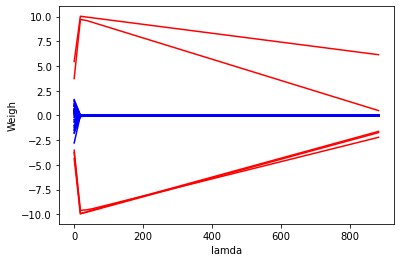

(n = 50,m = 1000)


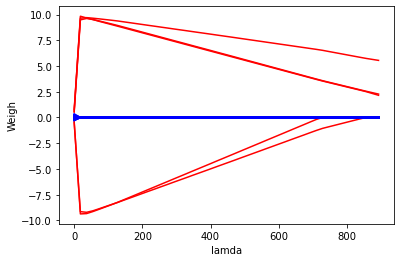

(n = 100,m = 75)


/Users/Hanna/opt/anaconda3/envs/myenv_python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


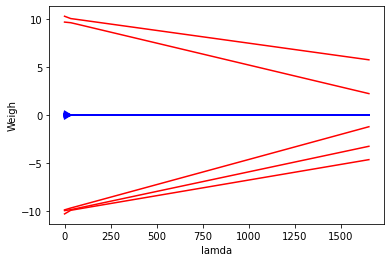

(n = 100,m = 150)


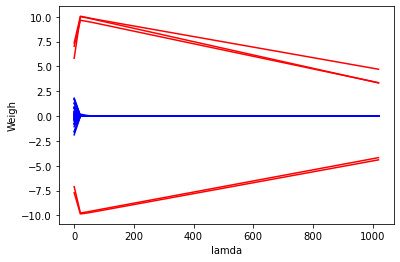

(n = 100,m = 1000)


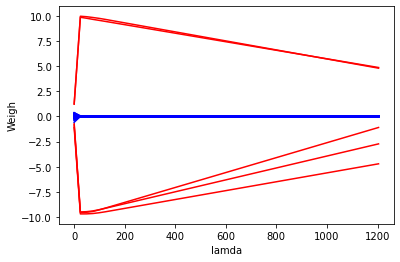

It seems like n = O(m) !


In [19]:
from operator import add
# Problem 2.4
# TODO: try another 5 different choices of (n,d) 
# (n = 50,m = 75),(n = 50,m = 150),(n = 50,m = 1000),(n = 100,m = 75),(n = 100,m = 150),(n = 100, m = 1000)
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
print("Problem 3(d)")
print("(n = 50,m = 75)")
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)
#RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

print("(n = 50,m = 150)")
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)
#RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

print("(n = 50,m = 1000)")
X, y, w_true, w0_true = DataGenerator(n=50, d=1000, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)
#RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

print("(n = 100,m = 75)")
X, y, w_true, w0_true = DataGenerator(n=100, d=75, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)
#RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

print("(n = 100,m = 150)")
X, y, w_true, w0_true = DataGenerator(n=100, d=150, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)
#RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

print("(n = 100,m = 1000)")
X, y, w_true, w0_true = DataGenerator(n=100, d=1000, k=5, sigma=1.0)
W, W0, Lmda = LassoPath(X, y)
#RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)

print("It seems like n = O(m) !")

In [21]:
# Problem 2.5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)


In [22]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsqr

# TODO: coordinate descent of lasso, note lmda stands for lambda
def lasso_sparse(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
    n_iter = 0
    e = 100
    cost_list = []
    # Init
    X = csr_matrix(X) # sparse matrix
    W, w0 = Initialw(X, y) 
    W = np.reshape(W, (W.shape[0], 1))
    
    W_prev = np.copy(W)
    w0_prev = w0
    H_theta = w0 + X.dot(W)
    
    print(X.shape, y.shape)
    
    while((e>epsilon) and (n_iter<max_iter)):
        # coordinate descent algorithm
        #w0 = w0 - (1/X.shape[0])*(H_theta-y).sum()
        w0 = (H_theta-y).sum()/X.shape[0]
        for k in range(X.shape[1]): # number of features
            Rk = y - (X.dot(W)-X[:,k]*W[k])
            #Ak = 2*(np.square(X[:,k])).sum()
            #Ak = 2*(X[:,k]@X[:,k]).sum()
            Ak = (X[:,k].multiply(X[:,k].T)).sum()
            Ck = 2*(Rk@X[:,k]).sum()
            Tk = np.sign(Ck)*max(0,abs(Ck)-lmda)/Ak
            W[k] = Tk
                
        H_theta = w0 + X.dot(W)
        #cost = round(((H_theta-y)*(H_theta-y)).sum() + lmda*(np.absolute(W)).sum(),2)
        cost = round(((H_theta-y)*(H_theta-y)).sum() ,2)
        cost_list.append(cost)
        
        # (Stopping criteria) Update e and iter++
        n_iter += 1
        if (n_iter > 0):
            e = max(np.max(np.absolute(W-W_prev)), abs(w0-w0_prev))
        W_prev = np.copy(W)
        w0_prev = w0
    
    #print("y: ", y[0:4])
    #print("H: ", H_theta[0:4])
    if (draw_curve == True):
        plt.plot(list(range(0,len(cost_list))), cost_list)
        plt.title("# Cost function")
        plt.xlabel("# of Coordination step")
        plt.ylabel("Cost Function")
        plt.show()

    return (W,w0)

In [ ]:
"""
print(w_lasso, w0_lasso )
print(w_lasso.shape)
H_theta = w0_lasso + X_train.dot(w_lasso)
cost = round(((H_theta-y)*(H_theta-y)).sum() + 0.01*(np.absolute(w_lasso)).sum(),2)
print(((H_theta-y)*(H_theta-y)).sum())
print(0.01*(np.absolute(w_lasso)).sum())
"""

In [38]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    X_train = csr_matrix(X_train) # sparse matrix
    #W, W0, Lmda = LassoPath(X_train, y_train)
    #RMSE, Sparsity, Precision, Recall = EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda)
    w_lasso, w0_lasso = lasso_sparse(X_train, y_train, lmda = 1, epsilon = 1.0e-1, max_iter = 100, draw_curve = False)
    lmda_best = 1
    return (w_lasso, w0_lasso, lmda_best)

In [ ]:
# Problem 2.5: predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('../data/star_data.mtx', '../data/star_labels.txt', '../data/star_features.txt', 30000, 5000)
#X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('../data/star_data.mtx', '../data/star_labels.txt', '../data/star_features.txt', 3000, 1000)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

# evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# print the top-10 features you found by lasso
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])

    
    

/Users/Hanna/opt/anaconda3/envs/myenv_python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


(30000, 2500) (30000,)
(5000, 2500) (5000,)
(10000, 2500) (10000,)
(30000, 2500) (30000,)
